In [19]:
import pathlib

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#### Step 1: Load & Preprocess Data

In [20]:
df = pd.read_csv(pathlib.Path("data") / "subset4_articles_with_sentiment_and_classification.csv", index_col=0)
#df = pd.read_csv(pathlib.Path("data") / "combined_articles_with_sentiment.csv", index_col=0)

In [21]:
outlet_data = pd.DataFrame({
    "source_name": [
        "Reuters", "The Irish Times", "Al Jazeera English", "BBC News", "ABC News",
        "The New York Times", "CNN", "CBS News", "Newsweek", "Business Insider",
        "The Wall Street Journal", "ESPN"
    ],
    "leaning": [
        "Center", "NA", "Left-Center", "Center", "Left-Center",
        "Left-Center", "Left", "Left-Center", "Center", "Center",
        "Center", "Left-Center"
    ]
})

outlet_scores = pd.DataFrame({
    "source_name": [
        "Reuters", "The Irish Times", "Al Jazeera English", "BBC News", "ABC News",
        "The New York Times", "CNN", "CBS News", "Newsweek", "Business Insider",
        "The Wall Street Journal", "ESPN"
    ],
    "leaning": [
        -0.89, 0, -2.30, -0.80, -1.42, -2.20, -1.30, -1.50, -0.45, -2.60, -0.20, -2.00
    ]
})

In [22]:
df = df.merge(outlet_scores, on='source_name')
print(df.shape)
df.head()
# Article mehr likes when größer outlett / Score = gesamt engagement
#  zwischen sentiment und leaning plot
# likes nach leaning (true news) (fake news)
# Wie engeaing ein post ist
# Score = wie engaging sind die socres normalerweise bei dem Newsauslett
# wie viele Scores gibt das Newsoutlet raus
# Score (x + y + z) --> Scores / Anzahl Artikel per Outlett = r != likes von einem einzlenen articles
# dämpfungsfaktor = Scores / Anzahl Artikel per Outlett
# Artikel engagementscore  *  dämpfungsfaktor
# dämfungsfaktor = Gesamt likes per Outlett / Anzahl Artikel per Outlett
# Artikel engagementscore plot mit leaning # und sentiment

(7046, 26)


,id,source_id,source_name,author,title,description,url,url_to_image,published_at,content,...,textblob_polarity,textblob_subjectivity,vader_neg,vader_neu,vader_pos,vader_compound,label,explanation,retrieved_context,leaning
0,287,the-irish-times,The Irish Times,Andrew Pulver,Kristen Stewart: I was told to tone down my se...,The Twilight actor says she was advised to sto...,https://www.irishtimes.com/culture/film/kriste...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T12:58:03Z,Kristen Stewart was told to stop holding her g...,...,0.250598,0.488836,0.025,0.847,0.128,0.9769,True,"The article appears to be factual, as it quote...",['Permission (film) | Permission is a romantic...,0.0
1,8561,cbs-news,CBS News,Grace Segers,2020 Democrats reveal third quarter fundraisin...,The contenders in the 2020 presidential race h...,https://www.cbsnews.com/live-news/2020-democra...,https://cbsnews3.cbsistatic.com/hub/i/r/2019/0...,2019-10-01T14:29:16Z,"By Grace Segers, Sarah Ewall-Wice\r\nOctober 1...",...,0.000000,0.100000,0.000,1.000,0.000,0.0000,True,The article appears to be discussing the fundr...,"['Democratic Party presidential primaries, 202...",-1.5
2,1497,cnn,CNN,"Leah Asmelash, CNN",A Minnesota woman was killed in a rare black b...,A Minnesota woman was attacked and killed by a...,https://www.cnn.com/2019/09/05/us/minnesota-wo...,https://cdn.cnn.com/cnnnext/dam/assets/1909051...,2019-09-05T16:46:13Z,NaN,...,-0.089000,0.392000,0.109,0.869,0.021,-0.9791,True,This article appears to be a factual report of...,"[""Night of the Grizzlies | Night of the Grizzl...",-1.3
3,10376,cnn,CNN,"David Williams, CNN",A cheerleader jumped off a homecoming float to...,Cheerleader Tyra Winters is Rockwall High Scho...,https://www.cnn.com/2019/10/03/us/cheerleader-...,https://cdn.cnn.com/cnnnext/dam/assets/1910031...,2019-10-03T14:51:32Z,NaN,...,0.022465,0.448420,0.064,0.859,0.077,0.0102,True,The article is about a 17-year-old cheerleader...,"[""Karen Link | Link is a NFL Cheerleader for t...",-1.3
4,206,espn,ESPN,Adam RittenbergESPN Senior Writer,Taggart: Dehydration possible factor in FSU loss,Florida State will monitor the Seminoles' hydr...,http://espn.go.com/college-football/story/_/id...,https://a2.espncdn.com/combiner/i?img=%2Fphoto...,2019-09-03T15:16:00Z,After watching Florida State wear down in Satu...,...,0.076696,0.403968,0.043,0.846,0.111,0.9713,True,The article reports on a real event in which F...,"[""2016 South Florida Bulls football team | The...",-2.0


In [23]:
df_blade = pd.read_csv(pathlib.Path('data') / "socialblade_data.csv")
df_blade

,News Outlet,Likes Gained (month),Talking About (month)
0,Reuters,31650,86974
1,The Irish Times,1545,46378
2,Al Jazeera English,11475,309561
3,BBC News,333098,958167
4,ABC News,93335,2058334
5,The New York Times,53852,715760
6,CNN,447519,1707052
7,CBS News,14807,1310533
8,Newsweek,28,300835
9,Business Insider,62374,491559


In [24]:
df['source_name'].value_counts()

source_name
BBC News              1235
The Irish Times       1230
CNN                   1113
The New York Times     974
Business Insider       907
CBS News               891
Al Jazeera English     491
ABC News               123
ESPN                    82
Name: count, dtype: int64

In [25]:
# Umbenennen der Spalte im zweiten DataFrame für den Join
df_counts = df['source_name'].value_counts().reset_index()
df_counts.columns = ['News Outlet', 'Count']

# Merge beider DataFrames auf Basis der Spalte "News Outlet"
merged_df = pd.merge(df_blade, df_counts, on='News Outlet', how='inner')

merged_df['scaling_factor'] = merged_df["Talking About (month)"] / merged_df["Count"]
merged_df = merged_df.rename(columns={'News Outlet': 'source_name'})
# Ergebnis anzeigen
print(merged_df.columns)
merged_df


Index(['source_name', 'Likes Gained (month)', 'Talking About (month)', 'Count',
       'scaling_factor'],
      dtype='object')


,source_name,Likes Gained (month),Talking About (month),Count,scaling_factor
0,The Irish Times,1545,46378,1230,37.705691
1,Al Jazeera English,11475,309561,491,630.470468
2,BBC News,333098,958167,1235,775.843725
3,ABC News,93335,2058334,123,16734.422764
4,The New York Times,53852,715760,974,734.866530
5,CNN,447519,1707052,1113,1533.739443
6,CBS News,14807,1310533,891,1470.856341
7,Business Insider,62374,491559,907,541.961411
8,ESPN,119154,1741852,82,21242.097561


In [26]:
df = pd.merge(df, merged_df[["source_name", "scaling_factor", "Count"]], on='source_name', how='left')

In [27]:
# normalization_type = "scaling_factor"
# df.dropna(axis=0, subset=['engagement_reaction_count'], inplace=True)
# df['scaled_engagement_reaction_count'] = df['engagement_reaction_count'] * df["scaling_factor"]
# df['scaled_engagement_all_count'] = (df['engagement_reaction_count'] + df['engagement_comment_count']  + df['engagement_share_count']  ) * df["scaling_factor"]

In [28]:
normalization_type = "divide_by_count"
df.dropna(axis=0, subset=['engagement_reaction_count'], inplace=True)
df['scaled_engagement_reaction_count'] = df['engagement_reaction_count'] / df["Count"]
df['scaled_engagement_all_count'] = (df['engagement_reaction_count'] + df['engagement_comment_count']  + df['engagement_share_count']  ) / df["Count"]

In [29]:
def min_max_normalize(column):
    return (column - column.min()) / (column.max() - column.min())

def z_score_normalize(column):
    return (column - column.mean()) / column.std()

df['scaled_engagement_reaction_count'] = min_max_normalize(df['scaled_engagement_reaction_count'])
df['scaled_engagement_all_count'] = min_max_normalize(df['scaled_engagement_all_count'])

In [30]:
df[['scaled_engagement_reaction_count', 'scaled_engagement_all_count']].head()

,scaled_engagement_reaction_count,scaled_engagement_all_count
0,0.000000,0.000000
1,0.000008,0.000014
2,0.000001,0.000012
3,0.000151,0.000315
4,0.000000,0.000000


#### Step 2: Plotting

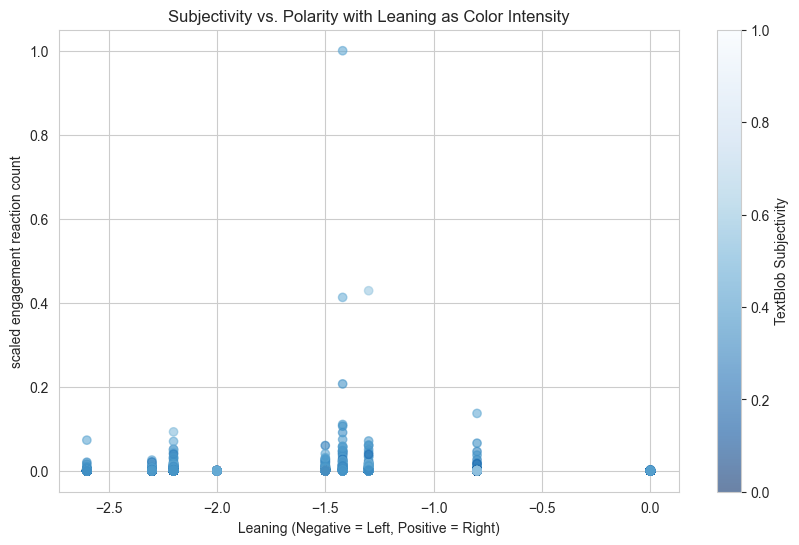

In [31]:
# Scatterplot of Subjectivity vs. Polarity with Leaning as Color Intensity
plt.figure(figsize=(10, 6))
y_var = "scaled_engagement_reaction_count"
scatter = plt.scatter(df['leaning'], df[y_var], c=df['textblob_subjectivity'], cmap='Blues_r', alpha=0.6)
plt.title('Subjectivity vs. Polarity with Leaning as Color Intensity')
plt.xlabel('Leaning (Negative = Left, Positive = Right)')
plt.ylabel(y_var.replace("_", " "))
colorbar = plt.colorbar(scatter)
colorbar.set_label('TextBlob Subjectivity')
plt.grid(True)
plt.show()

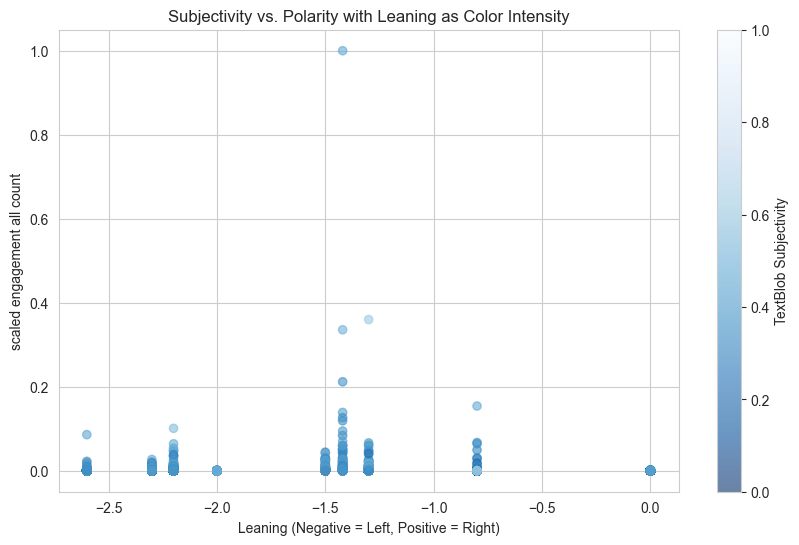

In [32]:
# Scatterplot of Subjectivity vs. Polarity with Leaning as Color Intensity
plt.figure(figsize=(10, 6))
y_var = "scaled_engagement_all_count"
scatter = plt.scatter(df['leaning'], df[y_var], c=df['textblob_subjectivity'], cmap='Blues_r', alpha=0.6)
plt.title('Subjectivity vs. Polarity with Leaning as Color Intensity')
plt.xlabel('Leaning (Negative = Left, Positive = Right)')
plt.ylabel(y_var.replace("_", " "))
colorbar = plt.colorbar(scatter)
colorbar.set_label('TextBlob Subjectivity')
plt.grid(True)
plt.show()

C:\Users\Amaan\AppData\Local\Temp\ipykernel_15448\3426388161.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x='leaning_bin', y=var_y, palette='Set2', width=0.5, showfliers=showfliers)  # Boxplot


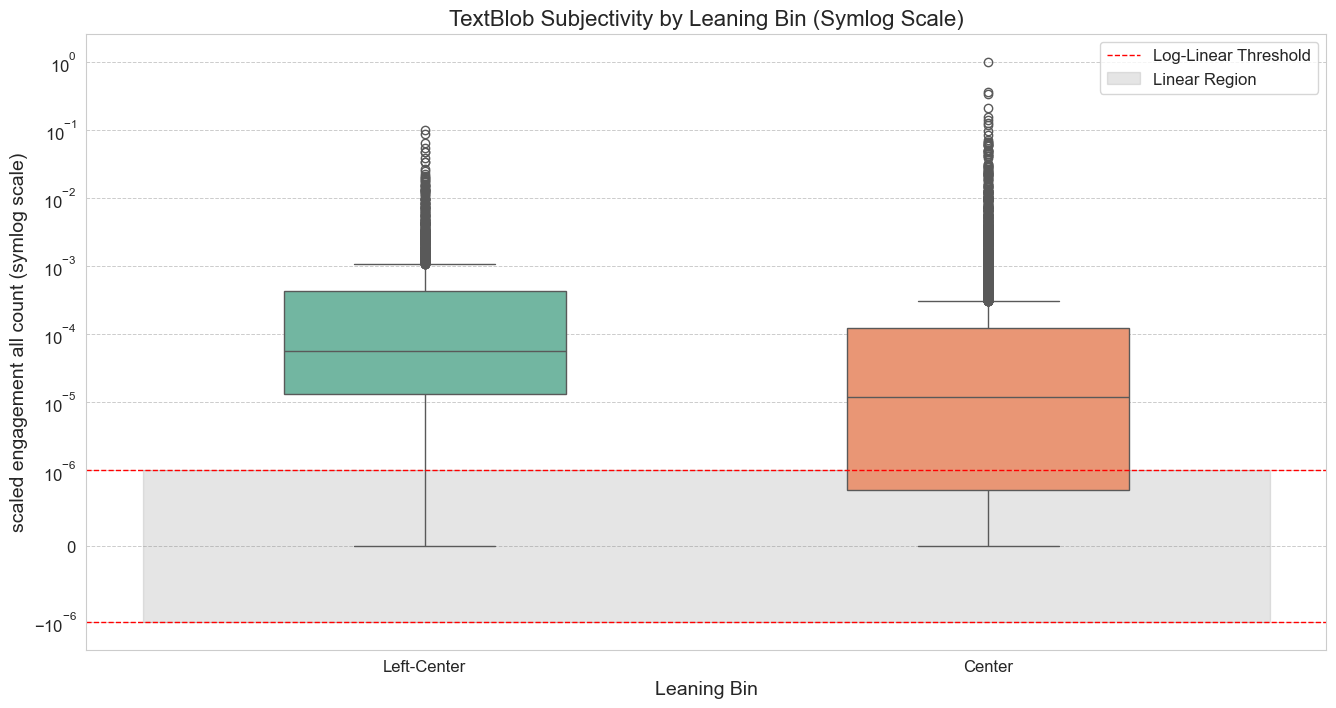

In [33]:
# Creating boxplots for Subjectivity and Polarity against Leaning
# For visualization purposes, I will create bins for the leaning scores and use those bins to create the boxplots.

# Create bins for 'leaning' (e.g., Left, Center, Right)
# Create bins for 'leaning'
y_var = "scaled_engagement_all_count"
df['leaning_bin'] = pd.cut(df['leaning'],
                           bins=[-float('inf'), -1.75, float('inf')],
                           labels=['Left-Center', 'Center'])
import numpy as np
# def make_boxplot(var_y, df=df):
#     #df = df[df[var_y] > 0]
#     plt.figure(figsize=(16, 8))  # Larger figure
#     ax = sns.boxplot(data=df, x='leaning_bin', y=var_y, palette='Set2', width=0.2)  # Boxplot
#     ax.set_yscale('symlog', linthresh=1e-6)  # Set y-axis to logarithmic scale
#
#     # # Adjust y-axis limits to account for outliers
#     # min_val = df[var_y][df[var_y] > 0].min()  # Find the smallest non-zero value
#     # max_val = df[var_y].max()
#     # plt.ylim(min_val * -0.1, max_val * 1.5)  # Add extra margin
#
#     plt.title('TextBlob Subjectivity by Leaning Bin (Log Scale)', fontsize=16)  # Larger title
#     plt.xlabel('Leaning Bin', fontsize=14)  # Larger x-axis label
#     plt.ylabel(f'{var_y.replace("_", " ")} (log scale)', fontsize=14)  # Y-axis label with "log scale"
#     plt.xticks(fontsize=12)  # Larger x-axis tick labels
#     plt.yticks(fontsize=12)  # Larger y-axis tick labels
#     plt.grid(axis='y', which='both', linestyle='--', linewidth=0.7)  # Optional: grid for better readability
#     plt.show()

def make_boxplot(var_y, df=df, linthresh=1e-6, showfliers=True):
    plt.figure(figsize=(16, 8))  # Larger figure
    ax = sns.boxplot(data=df, x='leaning_bin', y=var_y, palette='Set2', width=0.5, showfliers=showfliers)  # Boxplot
    ax.set_yscale('symlog', linthresh=linthresh)  # Set y-axis to symlog scale

    # Adding gridlines to indicate transitions between linear and log regions
    ax.axhline(y=linthresh, color='red', linestyle='--', linewidth=1, label='Log-Linear Threshold')
    ax.axhline(y=-linthresh, color='red', linestyle='--', linewidth=1)

    # Optional: Add a shaded region for the linear part
    plt.fill_between(
        [-0.5, len(df['leaning_bin'].unique()) - 0.5],
        -linthresh, linthresh,
        color='gray', alpha=0.2, label='Linear Region'
    )

    # Labels and title
    plt.title('TextBlob Subjectivity by Leaning Bin (Symlog Scale)', fontsize=16)  # Larger title
    plt.xlabel('Leaning Bin', fontsize=14)  # Larger x-axis label
    plt.ylabel(f'{var_y.replace("_", " ")} (symlog scale)', fontsize=14)  # Y-axis label with "log scale"
    plt.xticks(fontsize=12)  # Larger x-axis tick labels
    plt.yticks(fontsize=12)  # Larger y-axis tick labels
    plt.grid(axis='y', which='both', linestyle='--', linewidth=0.7)  # Optional: grid for better readability
    plt.legend(fontsize=12)  # Add a legend for the regions
    plt.show()

make_boxplot("scaled_engagement_all_count", df, 1e-6)




C:\Users\Amaan\AppData\Local\Temp\ipykernel_15448\1285915576.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x='leaning_bin', y=var_y, palette='Set2', width=0.2, showfliers=False)  # Boxplot


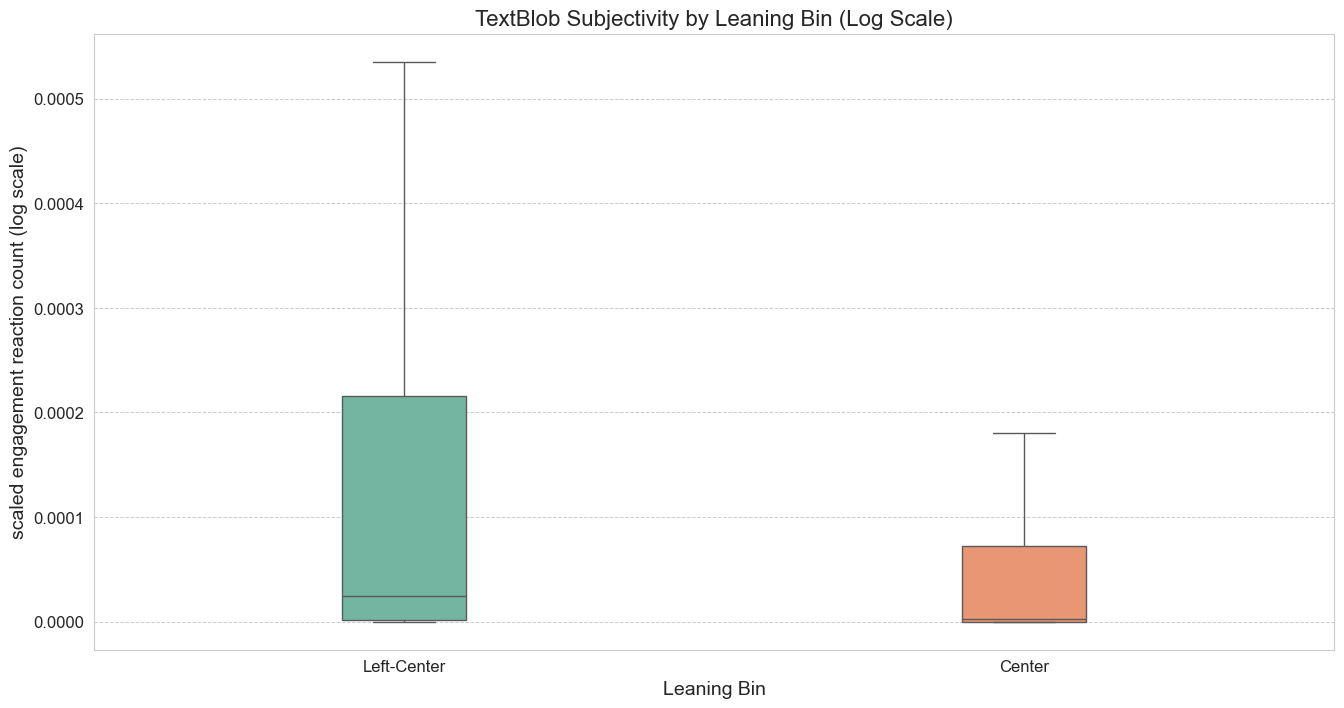

In [34]:
def make_boxplot_normal(var_y, df=df):
    plt.figure(figsize=(16, 8))  # Larger figure
    ax = sns.boxplot(data=df, x='leaning_bin', y=var_y, palette='Set2', width=0.2, showfliers=False)  # Boxplot


    # # Adjust y-axis limits to account for outliers
    # min_val = df[var_y][df[var_y] > 0].min()  # Find the smallest non-zero value
    # max_val = df[var_y].max()
    # plt.ylim(min_val * -0.1, max_val * 1.5)  # Add extra margin

    plt.title('TextBlob Subjectivity by Leaning Bin (Log Scale)', fontsize=16)  # Larger title
    plt.xlabel('Leaning Bin', fontsize=14)  # Larger x-axis label
    plt.ylabel(f'{var_y.replace("_", " ")} (log scale)', fontsize=14)  # Y-axis label with "log scale"
    plt.xticks(fontsize=12)  # Larger x-axis tick labels
    plt.yticks(fontsize=12)  # Larger y-axis tick labels
    plt.grid(axis='y', which='both', linestyle='--', linewidth=0.7)  # Optional: grid for better readability
    plt.show()

make_boxplot_normal("scaled_engagement_reaction_count", df)

C:\Users\Amaan\AppData\Local\Temp\ipykernel_15448\1285915576.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x='leaning_bin', y=var_y, palette='Set2', width=0.2, showfliers=False)  # Boxplot


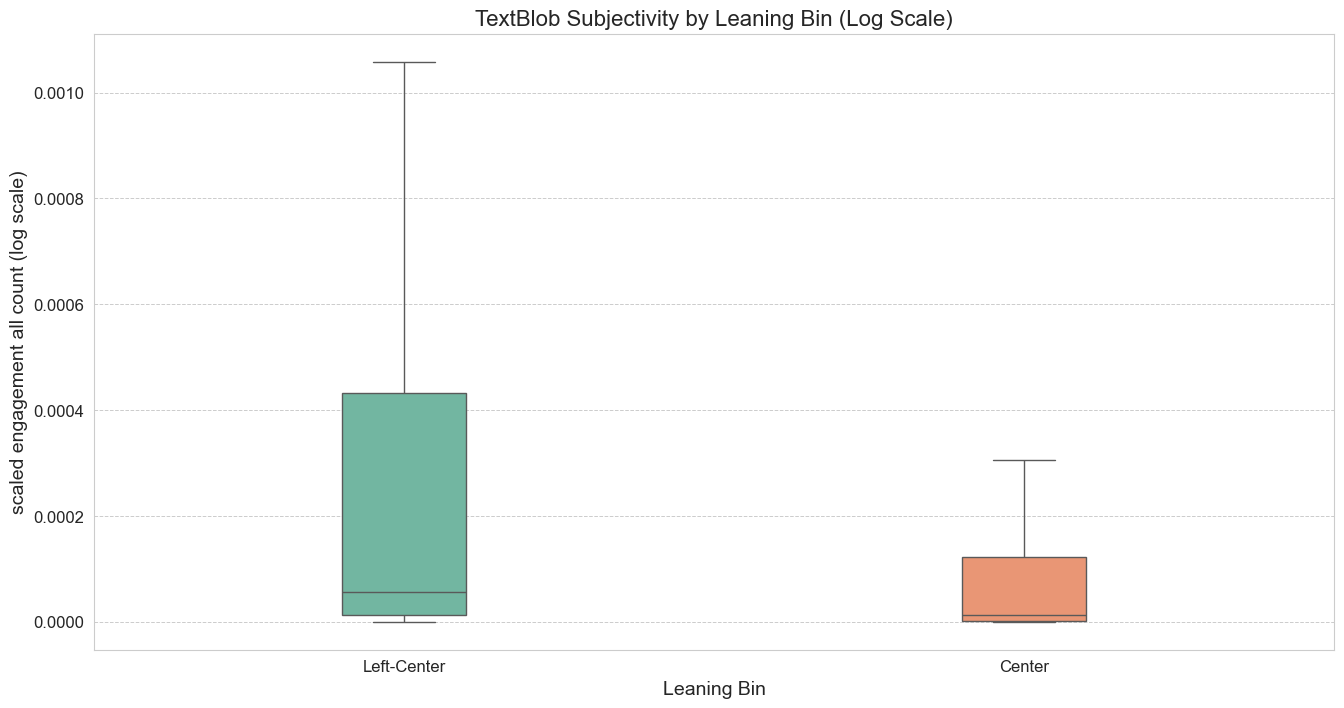

In [35]:
make_boxplot_normal("scaled_engagement_all_count", df)

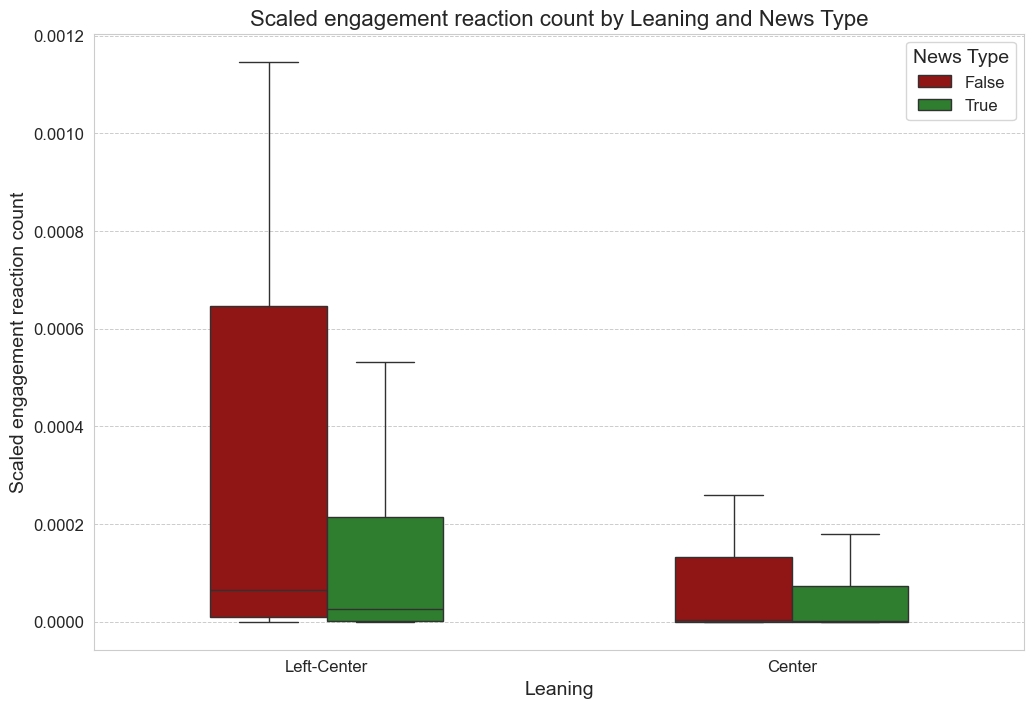

In [36]:
def make_boxplot_fake_news_and_leaning(var_y, df):
    plt.figure(figsize=(12, 8))  # Larger figure


    custom_palette = {False: "#a40000",  # Dark red for fake news
                      True: "#228B22"}   # Forest green for true news
    # Create a boxplot
    ax = sns.boxplot(
        data=df,
        x='leaning_bin',  # By political leaning
        y=var_y,          # Target variable
        hue='label',      # Split by Fake (False) or True (True)
        palette=custom_palette,   # Different colors for true/fake news
        width=0.5,        # Width of the boxes
        showfliers=False  # Hide outliers for clarity,
    )

    # Customize the title and axis labels
    plt.title(f'{var_y.replace("_", " ").capitalize()} by Leaning and News Type', fontsize=16)
    plt.xlabel('Leaning', fontsize=14)
    plt.ylabel(var_y.replace("_", " ").capitalize(), fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Add a legend for the hue (Fake vs True)
    plt.legend(title='News Type', loc='upper right', fontsize=12, title_fontsize=14)

    # Optional: Add gridlines for better readability
    plt.grid(axis='y', which='both', linestyle='--', linewidth=0.7)

    plt.savefig(pathlib.Path('img') / f"boxplot_leaning_{var_y}_normalization_{normalization_type}.png", dpi=800, bbox_inches='tight')
    # Display the plot
    plt.show()

# Call the updated function
make_boxplot_fake_news_and_leaning("scaled_engagement_reaction_count", df)


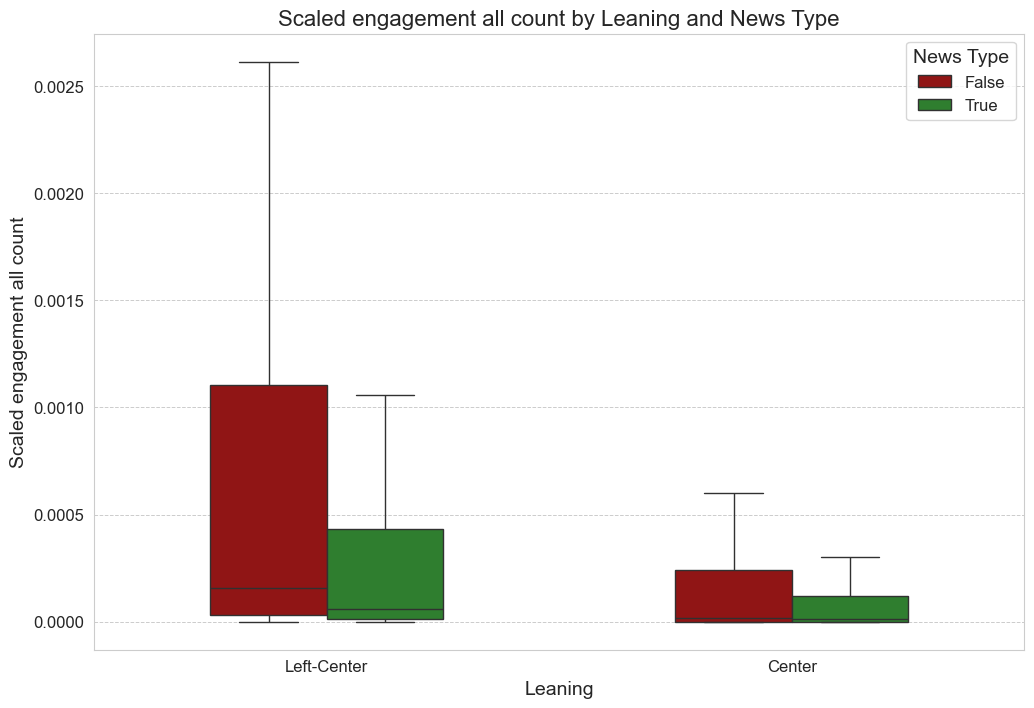

In [37]:
make_boxplot_fake_news_and_leaning("scaled_engagement_all_count", df)

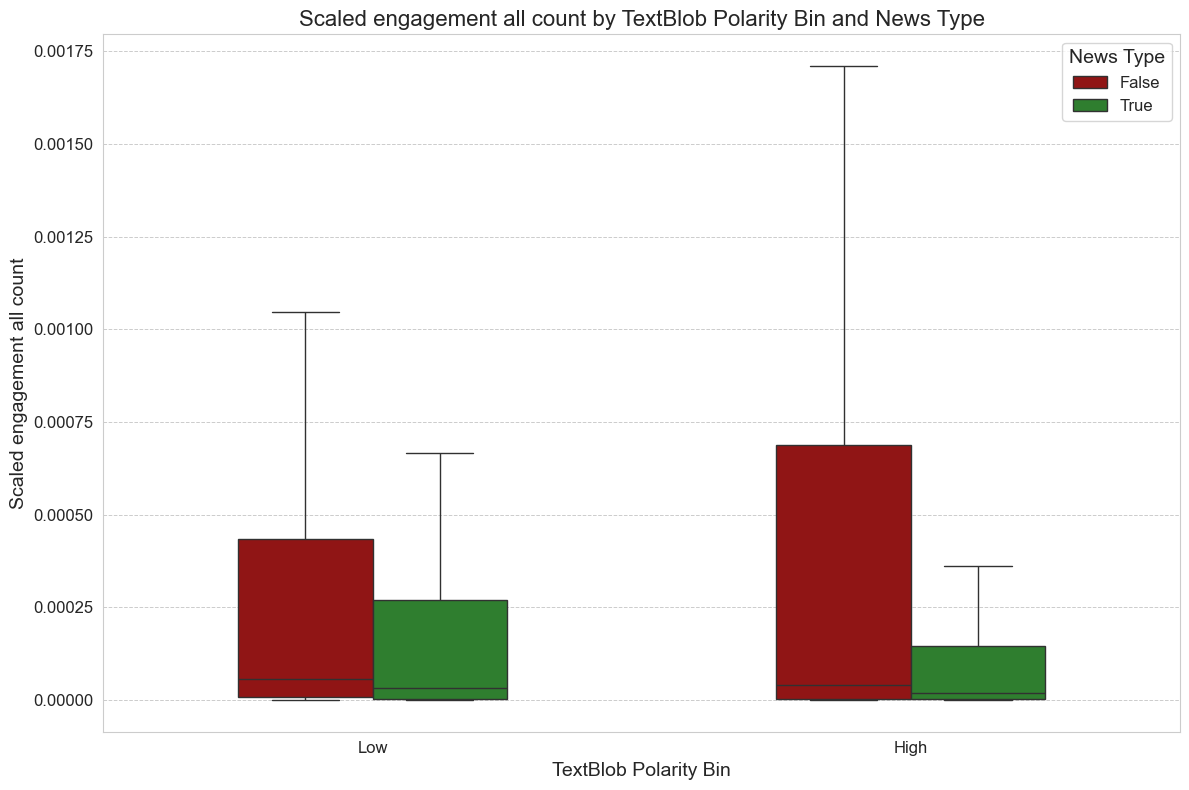

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def make_boxplot_textblob_polarity(var_y, df):
    # Ensure that 'textblob_polarity' exists in the DataFrame
    if 'textblob_polarity' not in df.columns:
        raise ValueError("The DataFrame does not contain a 'textblob_polarity' column.")

    catagories = ["Low", "High"] #["Low", "Medium", "High"]
    # Bin 'textblob_polarity' into three categories: Low, Medium, High
    # You can adjust the binning strategy as needed (e.g., equal width or quantiles)
    df['textblob_polarity_bin'] = pd.qcut(
        df['textblob_polarity'],
        q=len(catagories),
        labels=catagories
    )

    # Ensure the bins are ordered
    df['textblob_polarity_bin'] = pd.Categorical(
        df['textblob_polarity_bin'],
        categories=catagories,
        ordered=True
    )

    plt.figure(figsize=(12, 8))  # Larger figure

    custom_palette = {False: "#a40000",  # Dark red for fake news
                      True: "#228B22"}   # Forest green for true news

    # Create a boxplot
    ax = sns.boxplot(
        data=df,
        x='textblob_polarity_bin',  # Binned TextBlob polarity
        y=var_y,                    # Target variable
        hue='label',                # Split by Fake (False) or True (True)
        palette=custom_palette,     # Different colors for true/fake news
        width=0.5,                  # Adjusted width for better visibility
        showfliers=False            # Hide outliers for clarity
    )

    # Customize the title and axis labels
    plt.title(f'{var_y.replace("_", " ").capitalize()} by TextBlob Polarity Bin and News Type', fontsize=16)
    plt.xlabel('TextBlob Polarity Bin', fontsize=14)
    plt.ylabel(var_y.replace("_", " ").capitalize(), fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Add a legend for the hue (Fake vs True)
    plt.legend(title='News Type', loc='upper right', fontsize=12, title_fontsize=14)

    # Optional: Add gridlines for better readability
    plt.grid(axis='y', which='both', linestyle='--', linewidth=0.7)

    # Adjust layout for better fit
    plt.tight_layout()

    # Display the plot
    plt.show()

# Example usage:
# Assuming you have a DataFrame `df` with 'textblob_polarity' and 'label' columns
# and the target variable you want to plot is 'scaled_engagement_reaction_count'

make_boxplot_textblob_polarity("scaled_engagement_all_count", df)


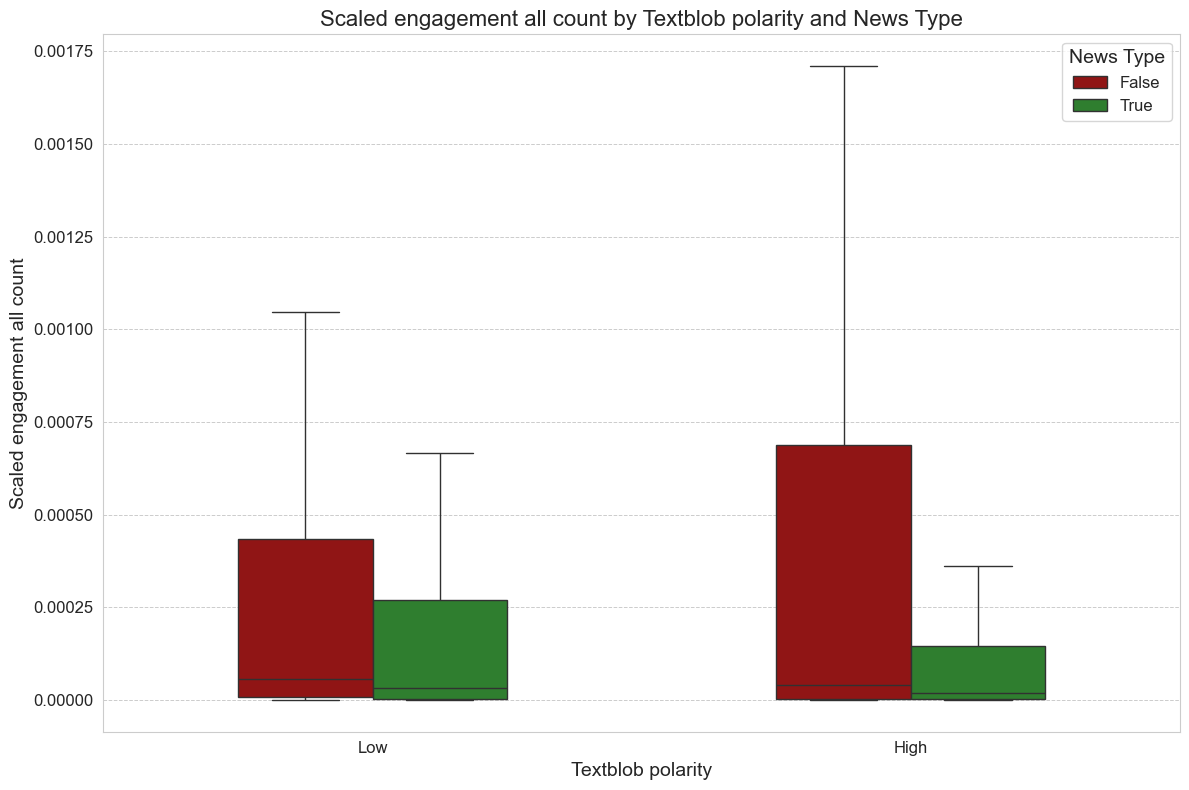

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def make_boxplot_textblob(var_x, var_y, df, categories=["Low", "High"]):
    """
    Creates a boxplot for a specified TextBlob metric against a target variable,
    categorized into defined bins and split by news type.

    Parameters:
    - var_x (str): The column name for the TextBlob metric (e.g., 'textblob_polarity').
    - var_y (str): The target variable to plot on the y-axis.
    - df (pd.DataFrame): The DataFrame containing the data.
    - categories (list of str, optional): Labels for the binned categories. Default is ["Low", "High"].

    Raises:
    - ValueError: If the specified var_x column does not exist in the DataFrame.
    """

    # Check if the specified column exists
    if var_x not in df.columns:
        raise ValueError(f"The DataFrame does not contain a '{var_x}' column.")

    # Bin var_x into specified categories using quantiles
    df[f'{var_x}_bin'] = pd.qcut(
        df[var_x],
        q=len(categories),
        labels=categories
    )

    # Ensure the bins are ordered
    df[f'{var_x}_bin'] = pd.Categorical(
        df[f'{var_x}_bin'],
        categories=categories,
        ordered=True
    )

    plt.figure(figsize=(12, 8))  # Larger figure for better readability

    # Define a custom color palette for the 'label' hue
    custom_palette = {
        False: "#a40000",  # Dark red for fake news
        True: "#228B22"    # Forest green for true news
    }

    # Create the boxplot
    ax = sns.boxplot(
        data=df,
        x=f'{var_x}_bin',  # Binned TextBlob metric
        y=var_y,           # Target variable
        hue='label',       # Split by Fake (False) or True (True)
        palette=custom_palette,
        width=0.5,         # Adjusted width for better visibility
        showfliers=False   # Hide outliers for clarity
    )

    # Customize the title and axis labels
    plt.title(
        f'{var_y.replace("_", " ").capitalize()} by {var_x.replace("_", " ").capitalize()} and News Type',
        fontsize=16
    )
    plt.xlabel(f'{var_x.replace("_", " ").capitalize()}', fontsize=14)
    plt.ylabel(var_y.replace("_", " ").capitalize(), fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Add a legend for the hue (Fake vs True)
    plt.legend(title='News Type', loc='upper right', fontsize=12, title_fontsize=14)

    # Optional: Add gridlines for better readability
    plt.grid(axis='y', which='both', linestyle='--', linewidth=0.7)

    # Adjust layout for better fit
    plt.tight_layout()

    plt.savefig(pathlib.Path('img') / f"boxplot_{var_x}_{var_y}_normalization_{normalization_type}.png", dpi=800, bbox_inches='tight')
    # Display the plot
    plt.show()

make_boxplot_textblob("textblob_polarity", "scaled_engagement_all_count", df)


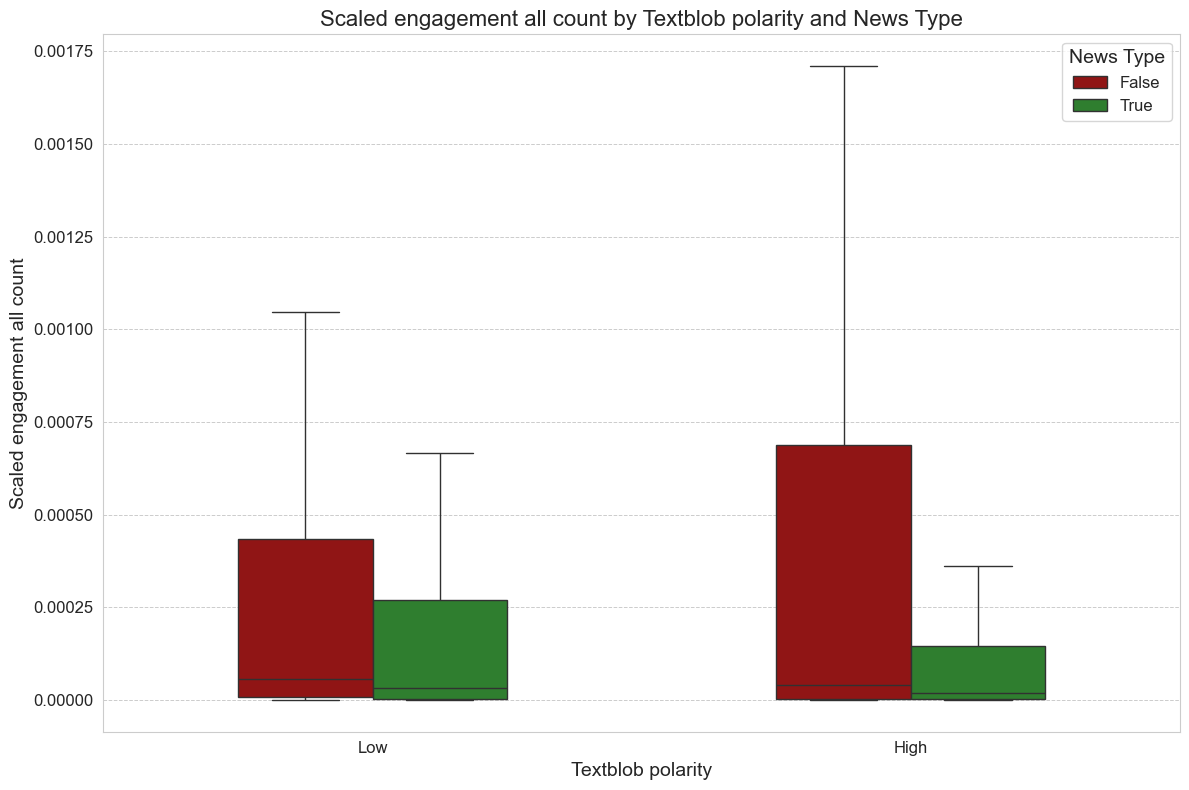

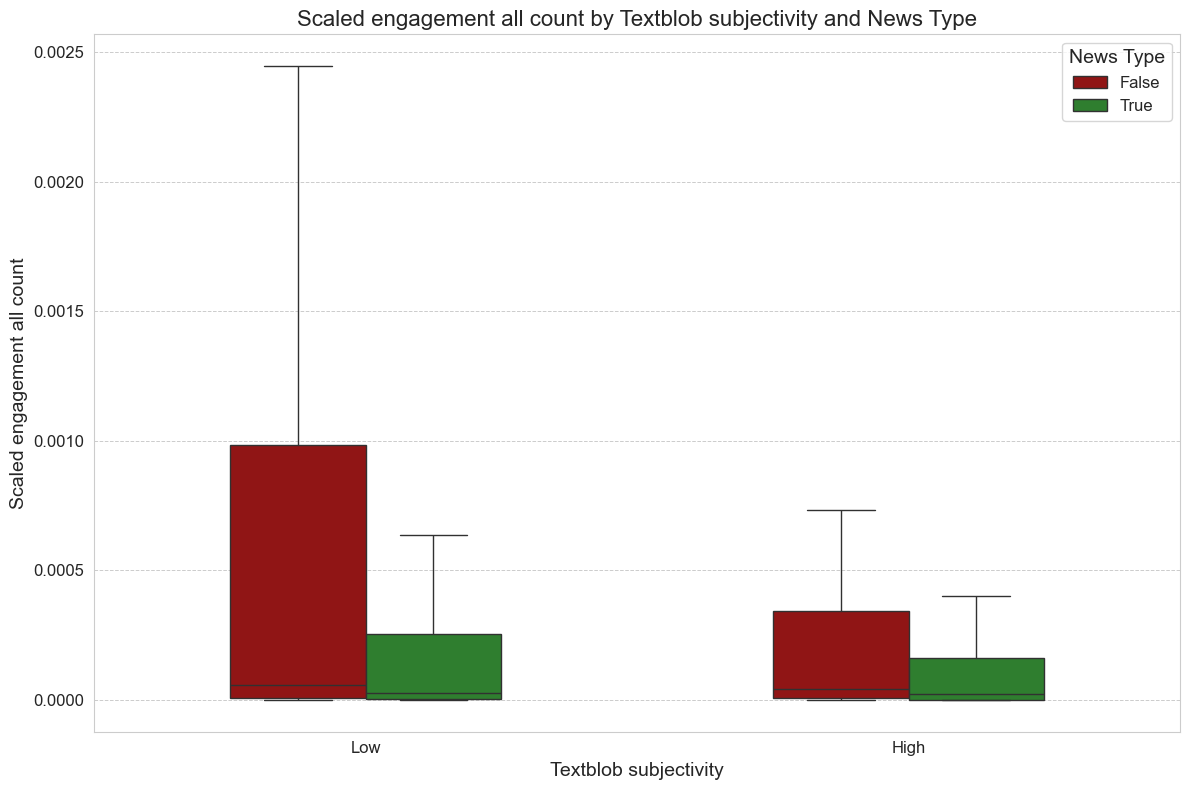

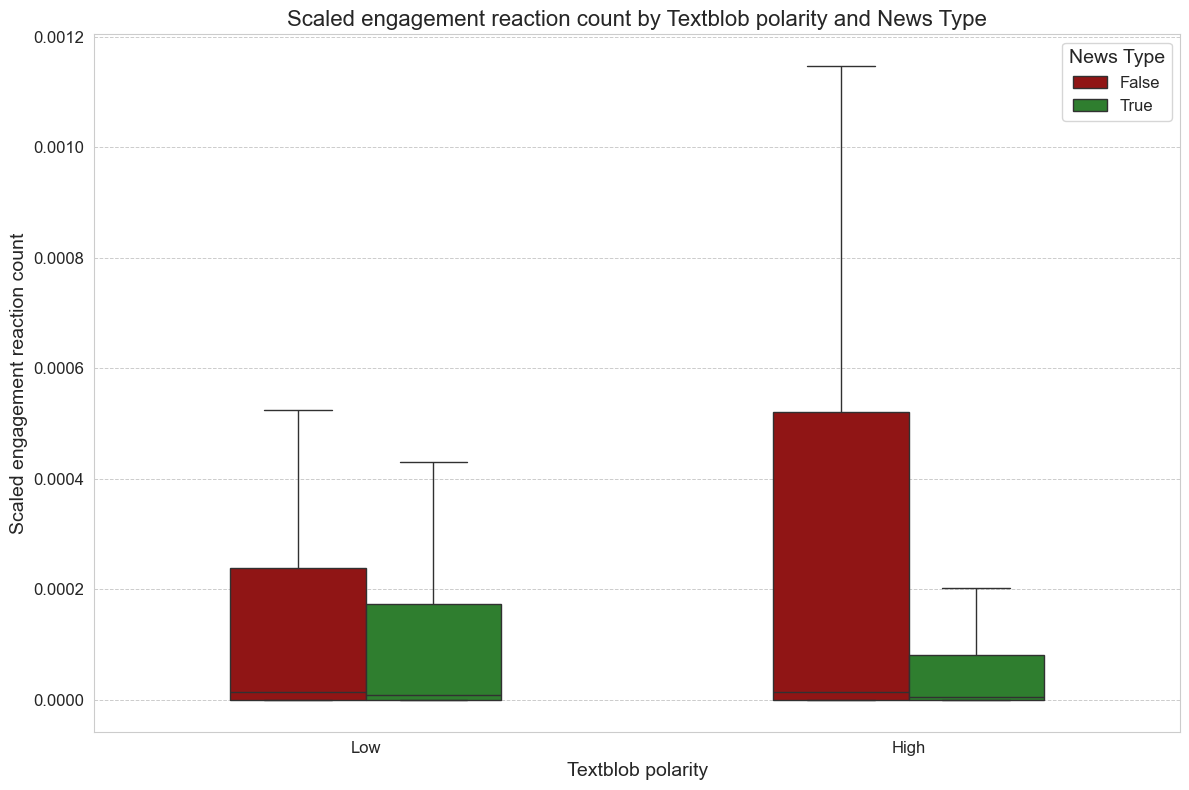

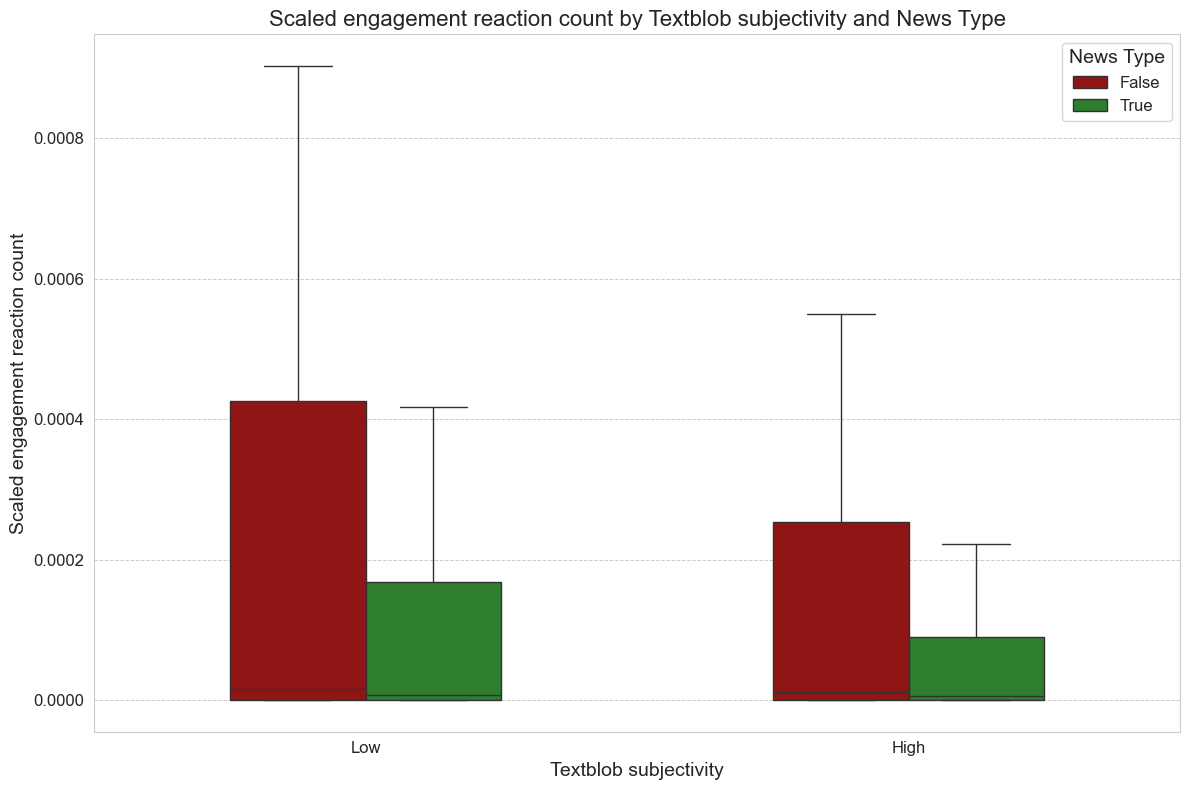

In [40]:
make_boxplot_textblob("textblob_polarity", "scaled_engagement_all_count", df)
make_boxplot_textblob("textblob_subjectivity", "scaled_engagement_all_count", df)
make_boxplot_textblob("textblob_polarity", "scaled_engagement_reaction_count", df)
make_boxplot_textblob("textblob_subjectivity", "scaled_engagement_reaction_count", df)

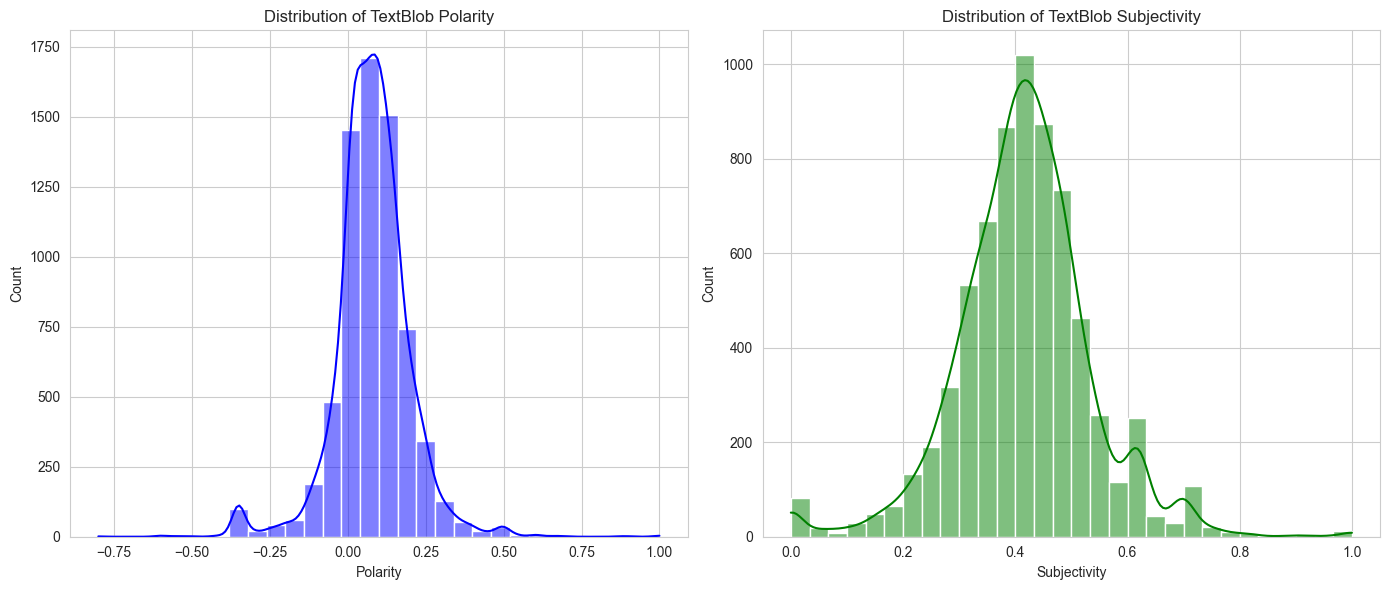

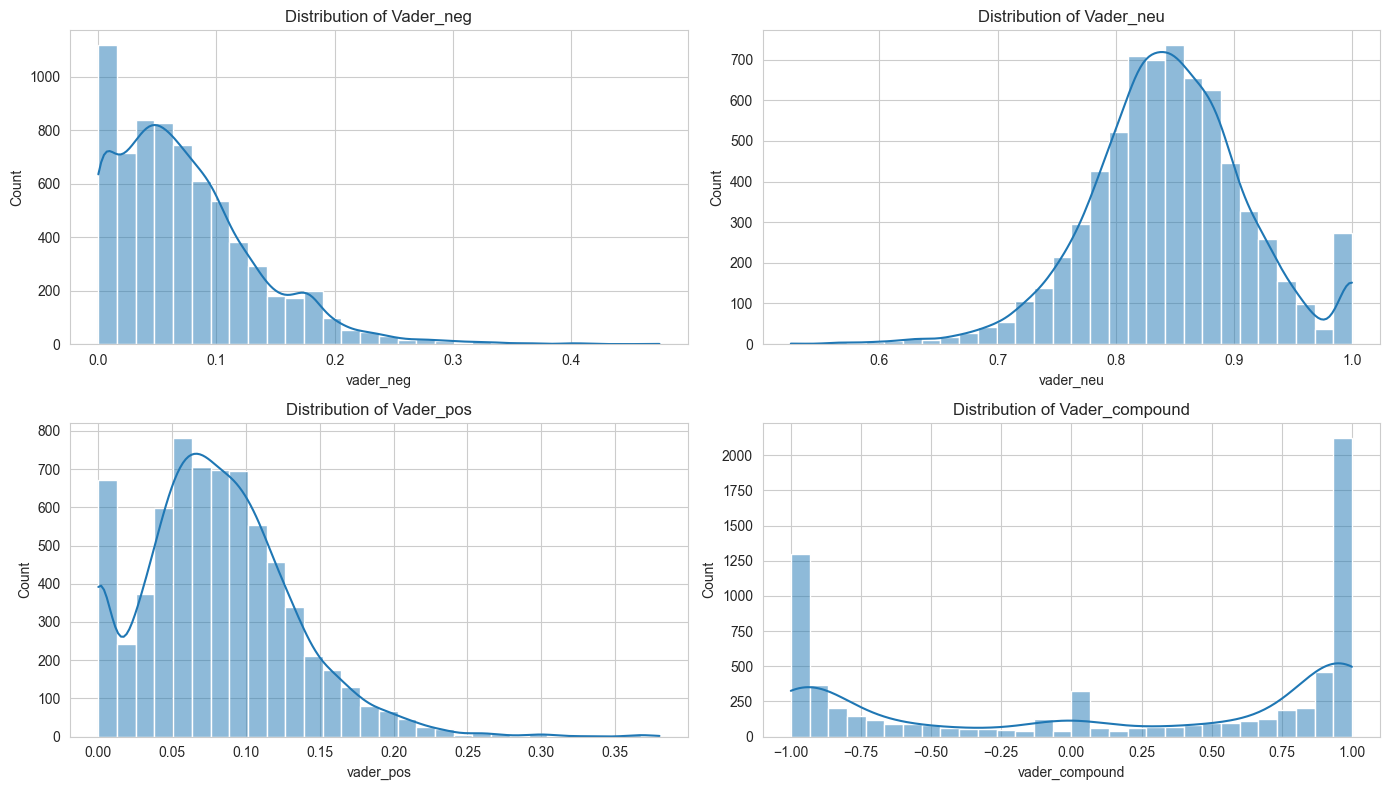

In [41]:
# 1. Distribution of TextBlob Sentiments
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['textblob_polarity'], kde=True, bins=30, color='blue')
plt.title('Distribution of TextBlob Polarity')
plt.xlabel('Polarity')

plt.subplot(1, 2, 2)
sns.histplot(df['textblob_subjectivity'], kde=True, bins=30, color='green')
plt.title('Distribution of TextBlob Subjectivity')
plt.xlabel('Subjectivity')

plt.tight_layout()
plt.show()

# 2. VADER Sentiment Distribution
plt.figure(figsize=(14, 8))
for i, col in enumerate(['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col.capitalize()}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

# # 3. Scatterplot of Polarity vs. Subjectivity
# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=df, x='textblob_polarity', y='textblob_subjectivity', hue='label', palette='Set1')
# plt.title('Polarity vs. Subjectivity (Colored by Label)')
# plt.xlabel('TextBlob Polarity')
# plt.ylabel('TextBlob Subjectivity')
# plt.legend(title='Label (True/False)')
# plt.show()

# # 4. Heatmap of Correlation
# plt.figure(figsize=(10, 8))
# sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title('Heatmap of Correlation')
# plt.show()

# # 5. Sentiment and Label Comparison
# plt.figure(figsize=(14, 6))
# plt.subplot(1, 3, 1)
# sns.boxplot(data=df, x='label', y='textblob_polarity', palette='Set2')
# plt.title('TextBlob Polarity by Label')
# plt.xlabel('Label (True/False)')

# plt.subplot(1, 3, 2)
# sns.boxplot(data=df, x='label', y='textblob_subjectivity', palette='Set2')
# plt.title('TextBlob Subjectivity by Label')
# plt.xlabel('Label (True/False)')

# plt.subplot(1, 3, 3)
# sns.boxplot(data=df, x='label', y='vader_compound', palette='Set2')
# plt.title('VADER Compound by Label')
# plt.xlabel('Label (True/False)')

# plt.tight_layout()
# plt.show()

# # 6. Leaning vs. Label Comparison
# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=df, x='leaning', y='vader_compound', hue='label', palette='Set1')
# plt.title('Leaning vs. VADER Compound (Colored by Label)')
# plt.xlabel('Leaning')
# plt.ylabel('VADER Compound')
# plt.show()

# 7. Stacked Bar Chart of Label by Leaning Categories
# df['leaning_category'] = pd.cut(df['leaning'], bins=[-1, -0.33, 0.33, 1], labels=['Left', 'Center', 'Right'])
# label_counts = df.groupby(['leaning_category', 'label']).size().unstack()
# label_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['salmon', 'skyblue'])
# plt.title('Label Proportions by Leaning Category')
# plt.xlabel('Leaning Category')
# plt.ylabel('Count')
# plt.legend(title='Label (True/False)')
# plt.show()

# 8. Leaning vs. Sentiment
# plt.figure(figsize=(14, 6))
# plt.subplot(1, 2, 1)
# sns.scatterplot(data=df, x='leaning', y='textblob_polarity', alpha=0.6)
# plt.title('Leaning vs. TextBlob Polarity')
# plt.xlabel('Leaning')
# plt.ylabel('Polarity')

# plt.subplot(1, 2, 2)
# sns.scatterplot(data=df, x='leaning', y='vader_compound', alpha=0.6)
# plt.title('Leaning vs. VADER Compound')
# plt.xlabel('Leaning')
# plt.ylabel('VADER Compound')

# plt.tight_layout()
# plt.show()

# # 9. Leaning Sentiment Polarity Density
# plt.figure(figsize=(10, 6))
# sns.kdeplot(data=df, x='textblob_polarity', hue='leaning_category', fill=True)
# plt.title('TextBlob Polarity Density by Leaning Category')
# plt.xlabel('Polarity')
# plt.ylabel('Density')
# plt.show()

# 10. True vs. Fake Leaning Comparison
# plt.figure(figsize=(8, 6))
# sns.boxplot(data=df, x='label', y='leaning', palette='Set2')
# plt.title('Leaning by Label')
# plt.xlabel('Label (True/False)')
# plt.ylabel('Leaning')
# plt.show()

# 11. 3D Scatterplot of Polarity, Subjectivity, and VADER Compound
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# scatter = ax.scatter(df['textblob_polarity'], df['textblob_subjectivity'], df['vader_compound'], c=df['label'], cmap='Set1', alpha=0.6)
# ax.set_title('3D Scatterplot of Polarity, Subjectivity, and VADER Compound')
# ax.set_xlabel('TextBlob Polarity')
# ax.set_ylabel('TextBlob Subjectivity')
# ax.set_zlabel('VADER Compound')
# legend1 = ax.legend(*scatter.legend_elements(), title="Label (True/False)")
# ax.add_artist(legend1)
# plt.show()

# 12. Clustering with KMeans (PCA for visualization)
# features = df[['textblob_polarity', 'textblob_subjectivity', 'vader_compound', 'leaning']]
# scaler = StandardScaler()
# features_scaled = scaler.fit_transform(features)

# Apply PCA for 2D visualization
# pca = PCA(n_components=2)
# features_pca = pca.fit_transform(features_scaled)

# # Apply KMeans
# kmeans = KMeans(n_clusters=3, random_state=42)
# df['cluster'] = kmeans.fit_predict(features_scaled)

# # Plot clusters
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=df['cluster'], palette='Set2')
# plt.title('KMeans Clustering (2D PCA Projection)')
# plt.xlabel('PCA Component 1')
# plt.ylabel('PCA Component 2')
# plt.legend(title='Cluster')
# plt.show()

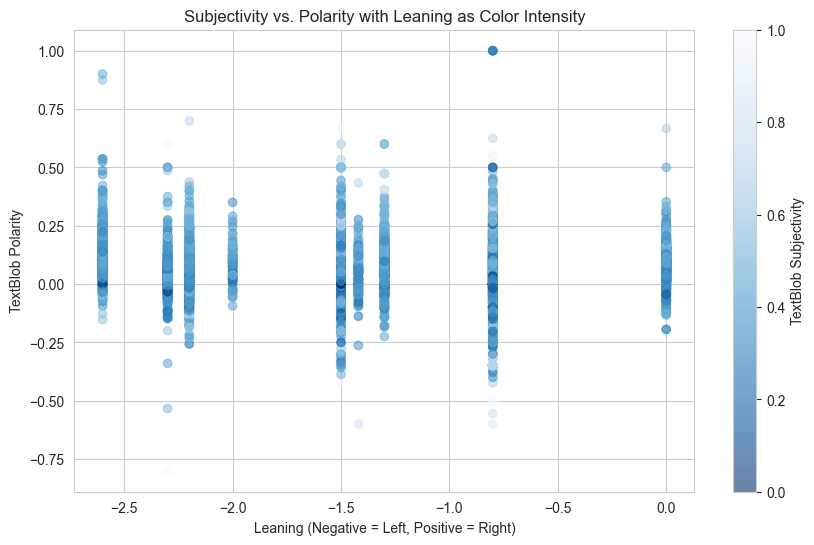

In [42]:
# Scatterplot of Subjectivity vs. Polarity with Leaning as Color Intensity

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['leaning'], df['textblob_polarity'], c=df['textblob_subjectivity'], cmap='Blues_r', alpha=0.6)
plt.title('Subjectivity vs. Polarity with Leaning as Color Intensity')
plt.xlabel('Leaning (Negative = Left, Positive = Right)')
plt.ylabel('TextBlob Polarity')
colorbar = plt.colorbar(scatter)
colorbar.set_label('TextBlob Subjectivity')
plt.grid(True)
plt.show()


C:\Users\Amaan\AppData\Local\Temp\ipykernel_15448\2727625510.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='leaning_bin', y='textblob_subjectivity', palette='Set2')


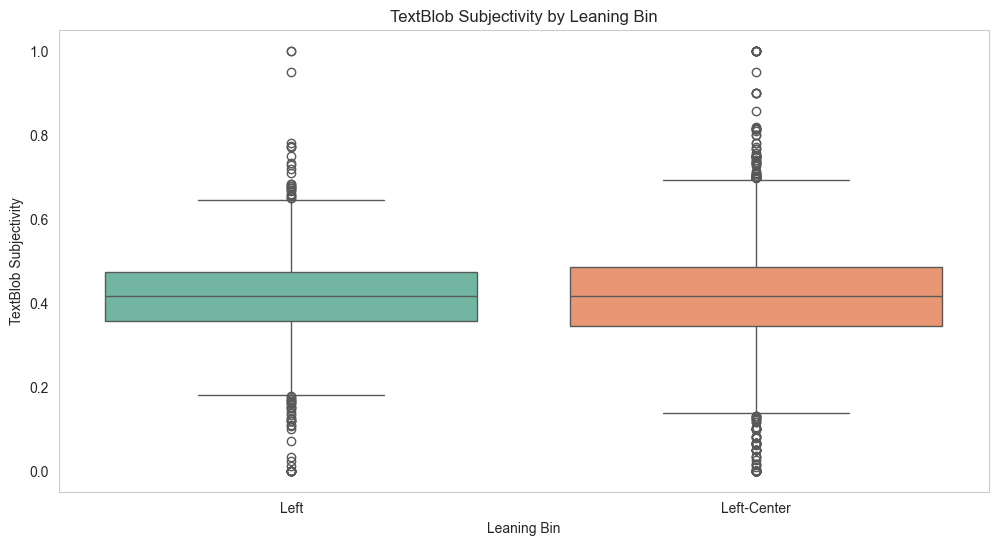

C:\Users\Amaan\AppData\Local\Temp\ipykernel_15448\2727625510.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='leaning_bin', y='textblob_polarity', palette='Set2')


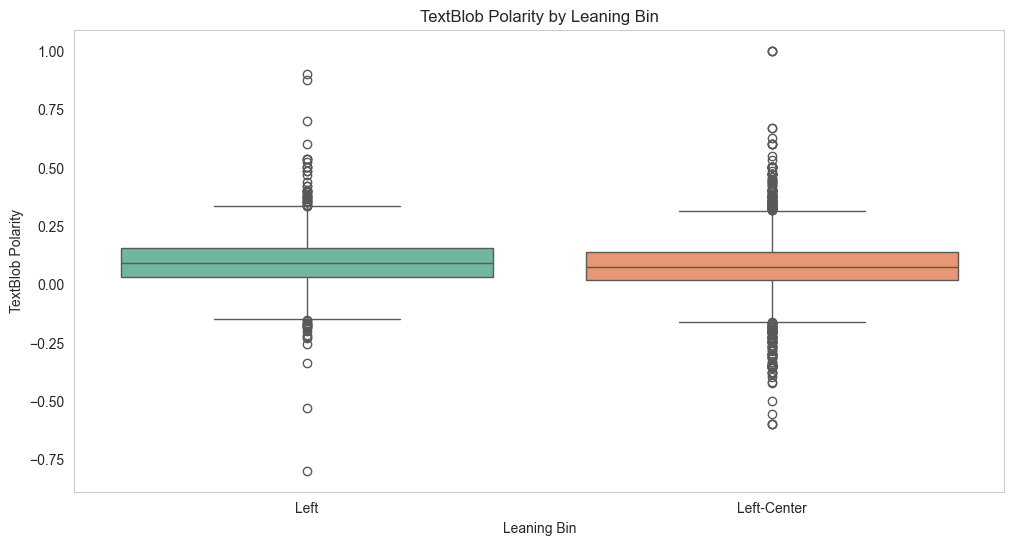

In [43]:
# Creating boxplots for Subjectivity and Polarity against Leaning
# For visualization purposes, I will create bins for the leaning scores and use those bins to create the boxplots.

# Create bins for 'leaning' (e.g., Left, Center, Right)
# Create bins for 'leaning'
df['leaning_bin'] = pd.cut(df['leaning'],
                           bins=[-float('inf'), -1.75, float('inf')],
                           labels=['Left', 'Left-Center'])

# Boxplot for Subjectivity by Leaning Bin
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='leaning_bin', y='textblob_subjectivity', palette='Set2')
plt.title('TextBlob Subjectivity by Leaning Bin')
plt.xlabel('Leaning Bin')
plt.ylabel('TextBlob Subjectivity')
plt.grid(axis='y')
plt.show()

# Boxplot for Polarity by Leaning Bin
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='leaning_bin', y='textblob_polarity', palette='Set2')
plt.title('TextBlob Polarity by Leaning Bin')
plt.xlabel('Leaning Bin')
plt.ylabel('TextBlob Polarity')
plt.grid(axis='y')
plt.show()



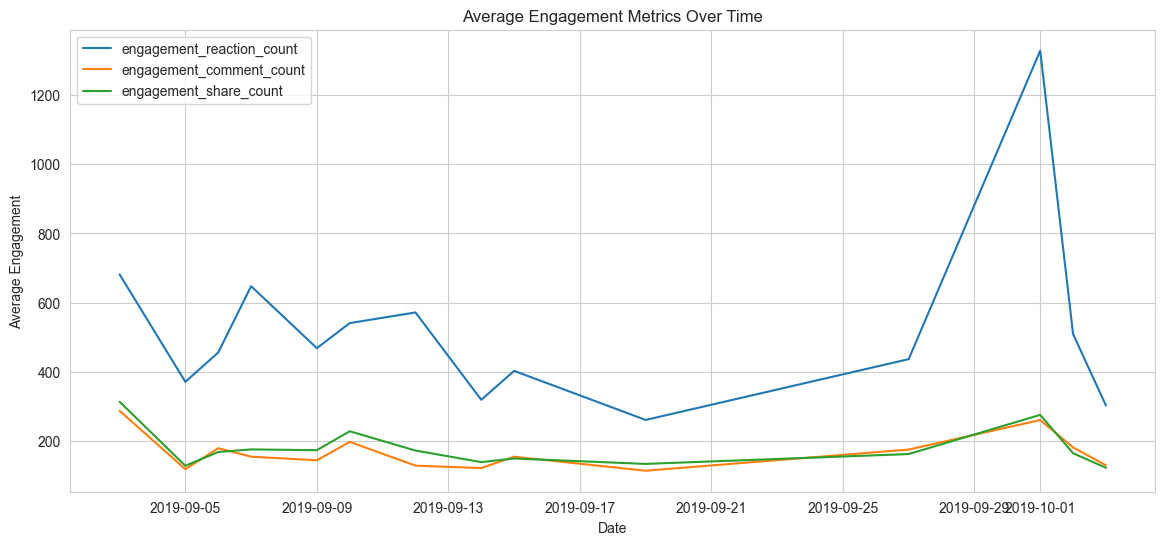

In [44]:
## MORE PLOTS (using engagement for example)
# Convert 'published_at' to datetime for time series analysis

# df['published_at'] = pd.to_datetime(df['published_at'])
# Convert 'published_at' to datetime, handling ISO 8601 format
df['published_at'] = pd.to_datetime(df['published_at'], format='ISO8601', errors='coerce')

# Check for rows that could not be converted
invalid_dates = df[df['published_at'].isna()]
if not invalid_dates.empty:
    print(f"Found {len(invalid_dates)} invalid date rows. You may want to inspect or clean these.")
    print(invalid_dates[['published_at']])

# Group by date and calculate average engagement metrics
engagement_time_series = df.groupby(df['published_at'].dt.date)[
    ['engagement_reaction_count', 'engagement_comment_count', 'engagement_share_count']
].mean()

# Plot the time series
plt.figure(figsize=(14, 6))
for col in engagement_time_series.columns:
    plt.plot(engagement_time_series.index, engagement_time_series[col], label=col)

plt.title('Average Engagement Metrics Over Time')
plt.xlabel('Date')
plt.ylabel('Average Engagement')
plt.legend()
plt.show()


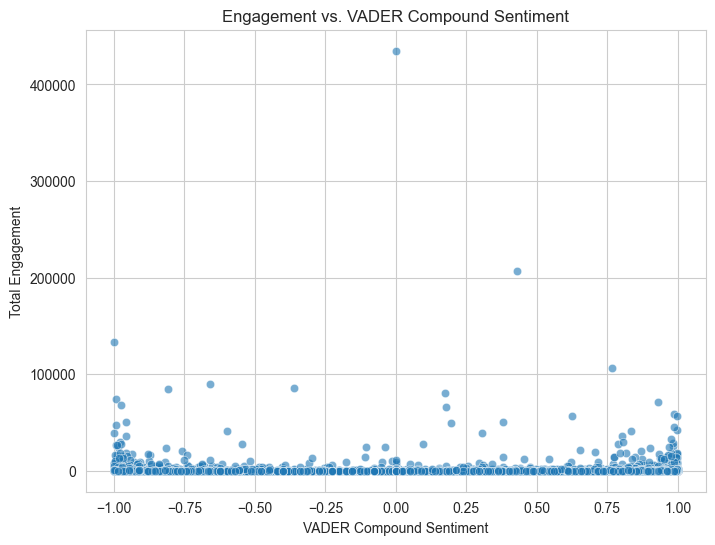

In [45]:
# Scatter plot of total engagement vs. VADER compound sentiment
df['total_engagement'] = (
    df['engagement_reaction_count'] + 
    df['engagement_comment_count'] + 
    df['engagement_share_count']
)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='vader_compound', y='total_engagement', alpha=0.6)
plt.title('Engagement vs. VADER Compound Sentiment')
plt.xlabel('VADER Compound Sentiment')
plt.ylabel('Total Engagement')
plt.show()


In [46]:
# from wordcloud import WordCloud
#
# # Generate word clouds for articles with extreme sentiment
# positive_content = " ".join(df[df['vader_compound'] > 0.5]['content'].dropna())
# negative_content = " ".join(df[df['vader_compound'] < -0.5]['content'].dropna())
#
# # Positive sentiment word cloud
# positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_content)
# plt.figure(figsize=(10, 6))
# plt.imshow(positive_wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.title('Word Cloud for Positive Sentiment Articles')
# plt.show()
#
# # Negative sentiment word cloud
# negative_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(negative_content)
# plt.figure(figsize=(10, 6))
# plt.imshow(negative_wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.title('Word Cloud for Negative Sentiment Articles')
# plt.show()


In [54]:
# plt.figure(figsize=(12, 6))
# sns.boxplot(data=df, x='source_name', y='total_engagement', showfliers=False)
# plt.title('Engagement Distribution by Source')
# plt.xlabel('Source Name')
# plt.ylabel('Total Engagement')
# plt.xticks(rotation=45, ha='right')
# plt.show()


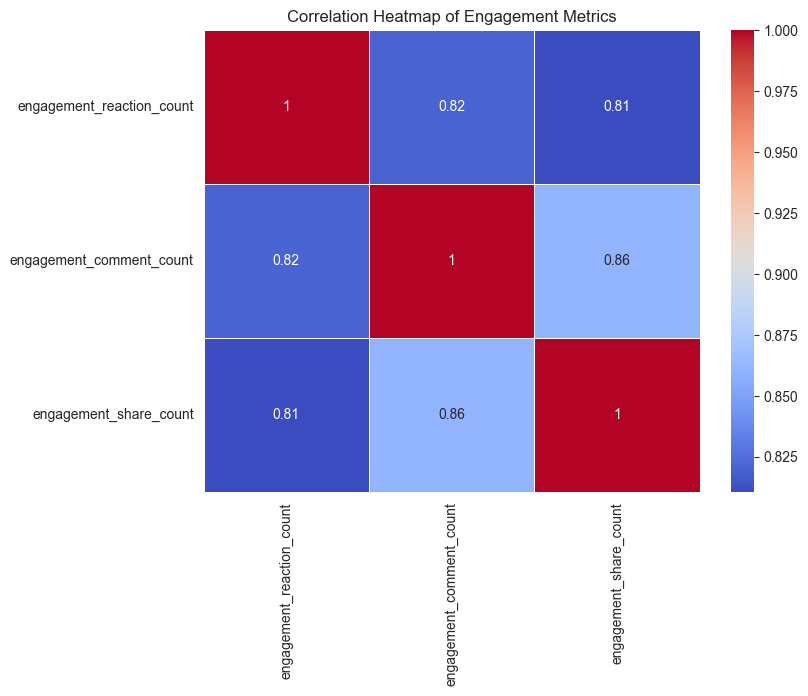

In [48]:
# Select engagement columns
engagement_metrics = df[
    ['engagement_reaction_count', 'engagement_comment_count', 'engagement_share_count']
]

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(engagement_metrics.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Engagement Metrics')
plt.show()

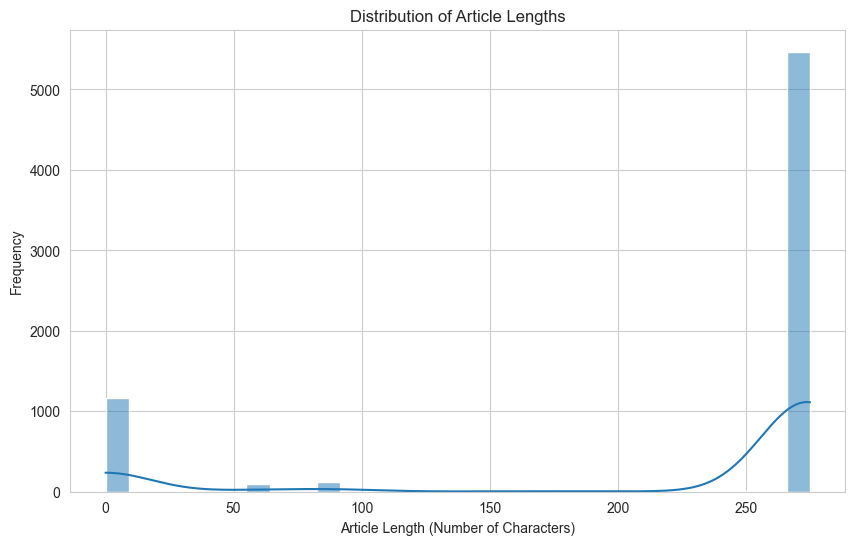

In [49]:
# Calculate article length
df['content_length'] = df['content'].apply(lambda x: len(x) if isinstance(x, str) else 0)

# Plot the distribution of article lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['content_length'], bins=30, kde=True)
plt.title('Distribution of Article Lengths')
plt.xlabel('Article Length (Number of Characters)')
plt.ylabel('Frequency')
plt.show()


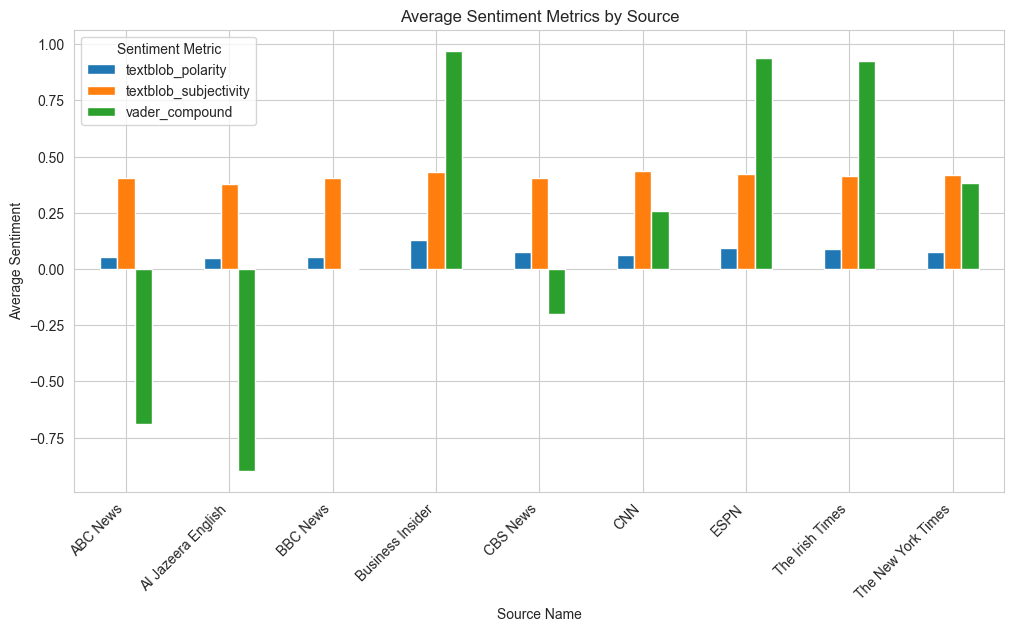

In [50]:
# Calculate average sentiment per source
avg_sentiment = df.groupby('source_name')[['textblob_polarity', 'textblob_subjectivity', 'vader_compound']].median()

# Plot average sentiment by source
avg_sentiment.plot(kind='bar', figsize=(12, 6))
plt.title('Average Sentiment Metrics by Source')
plt.xlabel('Source Name')
plt.ylabel('Average Sentiment')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment Metric')
plt.show()


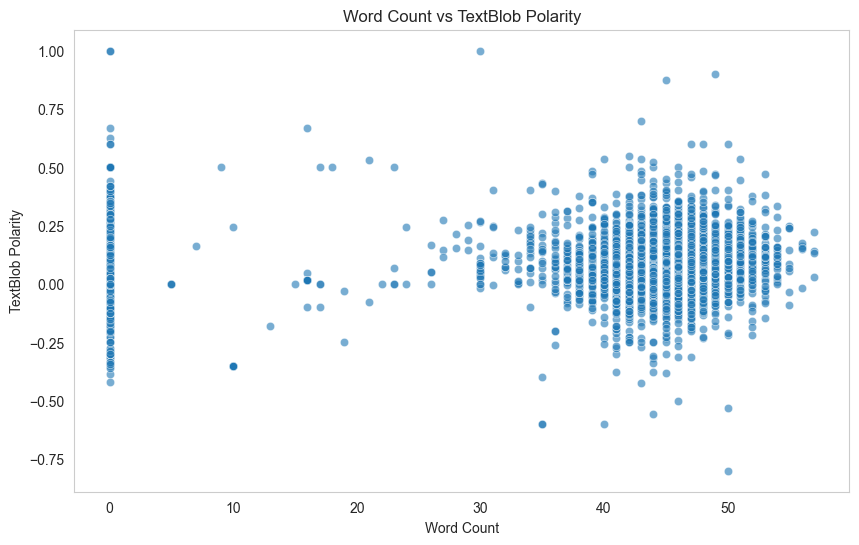

In [51]:
# Calculate word count
df['word_count'] = df['content'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

# Scatterplot of word count vs sentiment
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='word_count', y='textblob_polarity', alpha=0.6)
plt.title('Word Count vs TextBlob Polarity')
plt.xlabel('Word Count')
plt.ylabel('TextBlob Polarity')
plt.grid()
plt.show()

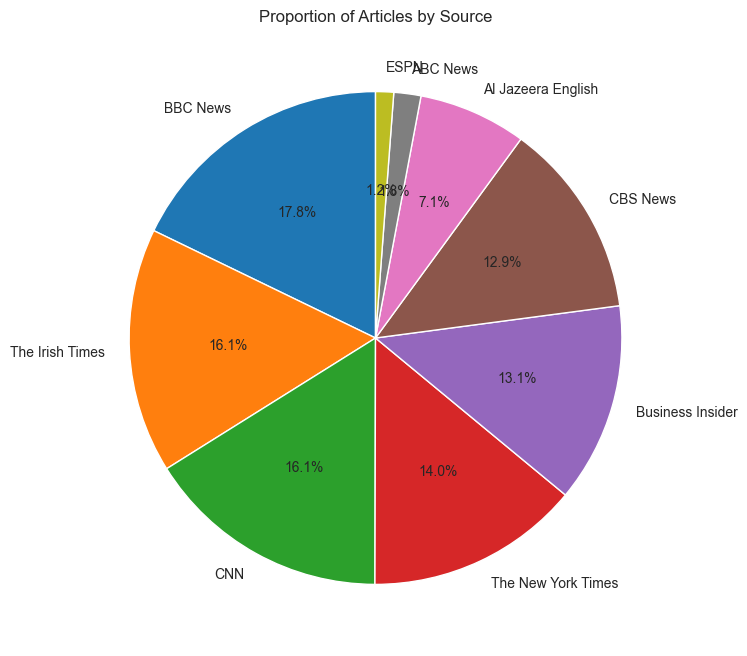

In [52]:
# Count articles per source
source_counts = df['source_name'].value_counts()

# Plot as a pie chart
plt.figure(figsize=(10, 6))
source_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, figsize=(8, 8))
plt.title('Proportion of Articles by Source')
plt.ylabel('')
plt.show()

In [53]:
import pathlib
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler